# CPM Predictor for Cognitive Score

In [17]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, t, ttest_1samp, pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.robust.robust_linear_model import RLM

import json
from joblib import dump

In [18]:
def normalise_correlate_fc(fmri):
    fc_emp = fmri / np.max(fmri)
    fc_emp = np.corrcoef(fc_emp)
    return fc_emp

In [19]:
def compute_correlation(fmri):
    epsilon = 1e-6
    
    # calculate Pearson correlation between nodes and Fisher z-transform
    corr_matrix = np.corrcoef(fmri)
    
    epsilon = 1e-6  # Small constant to add to the diagonal - to prevent division by zero in the arctanh function
    clipped_corr_matrix = np.clip(corr_matrix + epsilon, -1 + epsilon, 1 - epsilon)
    fisher_z_matrix = np.arctanh(clipped_corr_matrix)
    
    return fisher_z_matrix

In [16]:
ADAS_DATA = '../data/ADAS_ADNIGO23_17Apr2024_FILTERED_wfiles_197.csv'
df = pd.read_csv(ADAS_DATA)
df.shape

(600, 7)

## ADAS-Cog Predictor Model

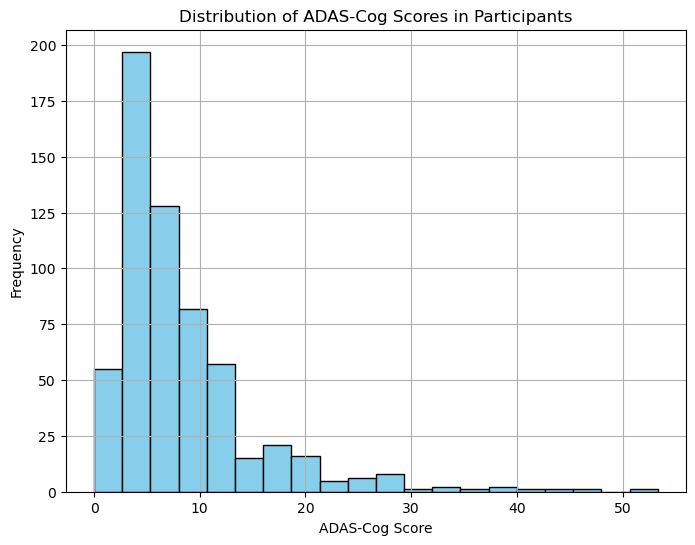

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(df['TOTSCORE'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of ADAS-Cog Scores in Participants')
plt.xlabel('ADAS-Cog Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.axis('on')
# plt.savefig('../data/adas_score_dist_20.png')

plt.show()

### Get the FC matrices

In [21]:
# Get features for training and testing - scans that are 197 long

# Get the FC data as numpy arrays
dim_x = len(df)
X = []

for i, file in enumerate(df['FC_DATA'].values):
    arr = loadmat(file)['ROI_activity'][:100, :] # get the first 100 regions
    fc = normalise_correlate_fc(arr)
    X.append(fc)

In [24]:
X = np.array(X)
X[0]

array([[ 1.        ,  0.17885745,  0.30978176, ..., -0.13870834,
         0.10412239, -0.08324907],
       [ 0.17885745,  1.        ,  0.50669997, ...,  0.33120821,
         0.23918715,  0.48246559],
       [ 0.30978176,  0.50669997,  1.        , ...,  0.0765841 ,
         0.07021674,  0.29910253],
       ...,
       [-0.13870834,  0.33120821,  0.0765841 , ...,  1.        ,
         0.60535591,  0.70500237],
       [ 0.10412239,  0.23918715,  0.07021674, ...,  0.60535591,
         1.        ,  0.62405544],
       [-0.08324907,  0.48246559,  0.29910253, ...,  0.70500237,
         0.62405544,  1.        ]])

In [25]:
Y = df['TOTSCORE']
Y.shape

(600,)

In [26]:
X.shape
X_transposed = np.transpose(X, (1, 2, 0))
X_transposed.shape

(100, 100, 600)

In [27]:
# threshold for feature selection
threshold = 0.01

In [28]:
num_subj = X_transposed.shape[2]
num_nodes = X_transposed.shape[0]

behav_pred_pos = np.zeros((num_subj, 1))
behav_pred_neg = np.zeros((num_subj, 1))
behav_pred = np.zeros((num_subj, 1))

In [ ]:
# Leave-one-subject-out cross validation

for leftout in range(0, 1):
    print('Leaving out subject ', leftout)
    
    # leave out subject from matrices and behaviour
    train_mats = np.delete(X_transposed, leftout, axis=2)  # Remove the left-out subject's matrix
    train_vcts = np.reshape(train_mats, (-1, train_mats.shape[2]))  # Reshape into vectors
    
    train_behav = np.delete(Y, leftout)  # Remove the left-out subject's behavior
    
    r_mat, p_mat = spearmanr(train_behav, train_vcts.T)
    print(r_mat.shape)
    
#     r_mat = r_mat[:num_nodes, :num_nodes]
#     p_mat = p_mat[:num_nodes, :num_nodes]
    
#     # setting thresholds and defining masks
#     pos_mask = np.zeros((num_nodes, num_nodes))
#     neg_mask = np.zeros((num_nodes, num_nodes))

#     # Find positive edges based on threshold
#     pos_edge = np.where((r_mat > 0) & (p_mat < threshold))

#     # Find negative edges based on threshold
#     neg_edge = np.where((r_mat < 0) & (p_mat < threshold))

#     pos_mask[pos_edge] = 1
#     neg_mask[neg_edge] = 1
    
#     # Form single-subject summary values - get sum of all edges and divide by 2 to account for
#     # symmetric matrices
#     train_sumpos = np.zeros(num_subj - 1)
#     train_sumneg = np.zeros(num_subj - 1)
    
#     for subj in range(num_subj-1):
#         train_sumpos[subj] = np.sum(np.sum(train_mats[:, :, subj] * pos_mask)) / 2
#         train_sumneg[subj] = np.sum(np.sum(train_mats[:, :, subj] * neg_mask)) / 2
        
#     # Build linear regression model on training data
#     # combining positive + negative features, without intercept
    
#     X_train = np.column_stack((train_sumpos, train_sumneg))
#     regressor = LinearRegression(fit_intercept=False)  
#     regressor.fit(X_train, train_behav)
    
#     # Predict on new data 
    
#     test_mat = X_transposed[:, :, leftout]
#     test_sumpos = np.sum(np.sum(test_mat * pos_mask)) / 2
#     test_sumneg = np.sum(np.sum(test_mat * neg_mask)) / 2
#     behav_pred[leftout] = regressor.predict([[test_sumpos, test_sumneg]])
    

Leaving out subject  0


In [23]:
pred = behav_pred[:20]
pred

array([[3.99386334],
       [5.71814362],
       [3.61249096],
       [1.83319304],
       [3.47831758],
       [1.18110968],
       [2.35670277],
       [2.60664379],
       [3.25347534],
       [3.92709034],
       [4.55827255],
       [3.96887772],
       [2.12107983],
       [1.59830511],
       [2.10437512],
       [1.36044212],
       [2.79972554],
       [3.08595544],
       [5.94863448],
       [5.6686587 ]])

In [24]:
actual = Y[:20]
actual

0      3.0
1      7.0
2      5.0
3      5.0
4      6.0
5      6.0
6     14.0
7      6.0
8      8.0
9      2.0
10     5.0
11     2.0
12     3.0
13     7.0
14     5.0
15    10.0
16     9.0
17     2.0
18     3.0
19     9.0
Name: TOTSCORE, dtype: float64

In [21]:
# Calculate MSE
mse = round(mean_squared_error(actual, pred),2)

print(f'mse: {mse}')

mse: 19.7


In [22]:
r2_score = round(r2_score(actual, pred),2)

print(f'r2: {r2_score}')

r2: -1.16
